<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we use four different classification algorithms to predict if a customer will pay off their loan on time or not. This is a binary classification problem.   
We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression
- Random Froests

The end-to-end pipeline used in this project composed of these steps: 
1. Download data
2. Exploratory data analysis
3. Data pre-processing
5. Predictive modeling based on training data:
    - Tune model parameter based on mode accuracy using k-fold cross-validation
    - Build final model
6. Use models to predict the target variable in new data
7. Report model accuracies and suggest the best classifier


#### Import libraries:

In [1]:
# import itertools # Functions creating iterators for efficient looping
import numpy as np # Support for large multi-dimensional matrices and high-level mathematical functions
import matplotlib.pyplot as plt # Visualization
# from matplotlib.ticker import NullFormatter
import pandas as pd # Data manipulations and analysis of numerical tables and time-series
# import matplotlib.ticker as ticker
from sklearn import preprocessing #provides common utility functions to change raw feature vectors into a representation that is more suitable for the downstream estimators.
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
%matplotlib inline 

#### Load data from a local Postgres server or directly from the web
The data is originally posted <a href="https://www.kaggle.com/zhijinzhai/loandata/activity">here </a>  on on Kaggle and includes customers who have paid off their loans or not. The data is splitte to two parts for training and test purposes. 
The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |



## 1. Download data

In [2]:
!wget -O loan_train.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
print('Download compelete!')
df = pd.read_csv('loan_train.csv')
print(df.shape)
df.head(3)


--2019-02-26 15:49:11--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
Resolving raw.githubusercontent.com... 151.101.248.133
Connecting to raw.githubusercontent.com|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23451 (23K) [text/plain]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.90K  --.-KB/s    in 0.01s   

2019-02-26 15:49:12 (1.86 MB/s) - 'loan_train.csv' saved [23451/23451]

Download compelete!
(346, 10)


,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


## 2. Data preparation and exploratory analysis

#### 2.1 Check features types

In [3]:
df.dtypes

user_id            int64
Un_named           int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Notice that "effective_date" and "due_date" are objects. We first convert their type to "date time".

##### Convert to date-time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df[['effective_date', 'due_date']].head(3)

,effective_date,due_date
0,2016-09-08,2016-10-07
1,2016-09-08,2016-10-07
2,2016-09-08,2016-09-22


#### 2.2 Basic exploratory analysis

##### Principal:

In [5]:
df['Principal'].value_counts(normalize = True)

1000    0.745665
800     0.234104
300     0.008671
500     0.005780
900     0.005780
Name: Principal, dtype: float64

##### Loan status: 

In [6]:
df['loan_status'].value_counts(normalize=True)

PAIDOFF       0.751445
COLLECTION    0.248555
Name: loan_status, dtype: float64

75% have paid off their loan on time while 25% have gone into collection.

##### Education level:

In [7]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

##### Gender:

In [8]:
df['Gender'].value_counts(normalize=True)

male      0.849711
female    0.150289
Name: Gender, dtype: float64

Male and female population 85%, 15%

##### Loan status by gender

In [9]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

About %86 of female population paid of their loan on time while this percentage is 73% for male population. This indicates that the **'gender'** feature might be a good candidate to predict the loan_status.

##### Loan status by educational level

In [10]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

This shows PAIDOFF rate is almost same between different educational groups, except the group with Master or Above, but notice that there are only 2 people in this category. So in summary the **education level** does not seem to have any effect on paying of the loan on time.

##### Loan status by Principal

In [11]:
df.groupby(['Principal'])['loan_status'].value_counts(normalize=True)

Principal  loan_status
300        PAIDOFF        1.000000
500        PAIDOFF        1.000000
800        PAIDOFF        0.777778
           COLLECTION     0.222222
900        PAIDOFF        1.000000
1000       PAIDOFF        0.736434
           COLLECTION     0.263566
Name: loan_status, dtype: float64

No difference is expected based on **Principal** amount.

##### Exploratory visualization:

In [12]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

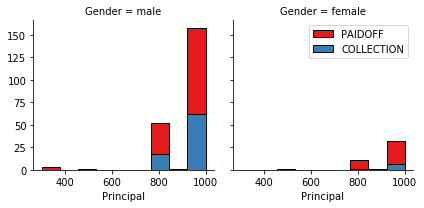

In [13]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

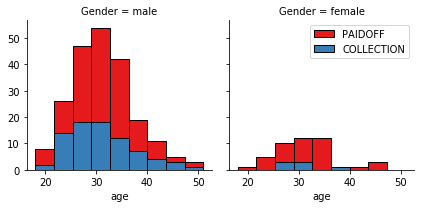

In [14]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

These graphs show that ignoring the 'gender' feature the on-time loan payment does not depend significantly on  'Principal' and 'Age' factors.

##### Convert Categorical features to numerical values

Convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head(2)

,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1


##### Create a new feature 
Look at the day of the week people get the loan: 

In [16]:
df['dayofweek'] = df['effective_date'].dt.dayofweek # Monday:0, Sunday:6
df.head(3)

,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3


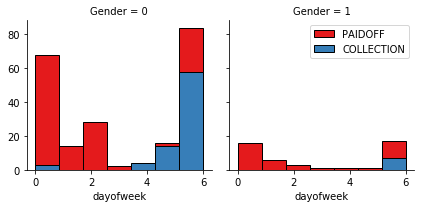

In [17]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use **Feature binarization** to set a threshold values less then day 4  for this new feature.

In [18]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(3)

,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0


##### One Hot Encoding  

Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data-Frame:

In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# Drop rows with education feature of'Master or Above'
# Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head(3)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1


## 3. Create Feature and Target dataset

##### Features:

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


##### Target variable:
The target attribute is a categorical variable with values: **[PAIDOFF**, **COLLECTIONS]**.  
That is why we will use classification models (and not the regression models) to predict the target variable.  
Since there are only two possible categories for target variable, the classification is a binary one.

In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

##### Normalized Features

Data Standardization: give data zero mean and unit variance. 
Many machine learning algorithms work based on Eucledian or similar measures of distance and normalization of data is a rquired step before applying almost of the Machine learning algorithms.

In [22]:
X_raw = X.values # A copy of raw feature values 
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108]])

In [23]:
X_raw[0:2]

array([[1000,   30,   45,    0,    0,    0,    1,    0,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0,    0]])

#### Select features with best ANOVA F-Values

In [24]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif


# # Create an SelectKBest object to select features with two best ANOVA F-Values
# fvalue_selector = SelectKBest(f_classif, k=5)

# # Apply the SelectKBest object to the features and target
# fvalue_selector.fit(X, y) # train the model
# X_kbest = fvalue_selector.transform(X) # transform data using the model

In [25]:
# # Show results
# print('Original number of features:', X.shape[1])
# print('Reduced number of features:', X_kbest.shape[1])

Feature selection based on ANOVA F-Value: I examined this method by selecting the 3, 4, or 5 best features, but none of these improved the model accuracy. The results for the 5 best features are reported at the end of this notebook. 

#### 4. Predictive modeling based on loaded data: 

#### Parameter tuning with cross-validation  
Parameter tuning for each machine learning model: Find the model parameter value to build the model with best accuracy. The model accuracy is evaluated by performing **10-fold cross-validation**. The model accuracy is measured using:
- **F1-score**:weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: $$F1 = 2 * \frac{\text{precision} *\text{ recall}}{\text{precision} + \text{recall}}$$ Precision and recall are demonstrated as: <a href="https://en.wikipedia.org/wiki/Precision_and_recall"><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="200" align="center"></a>
    - Precision: What proportion of positive identifications was actually correct? $$\text{Precision}= \frac{\text {TP}}{\text{TP+FP}}$$
    - Recall (sensitivity): What proportion of actual positives was identified correctly? $$\text{Recall}= \frac{\text {TP}}{\text{TP+FN}} $$
- **Jaccard similarity index**: The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union 

Function to plot model accuracy based on k-fold cross-validation:

In [26]:
def model_eval_plt(par, F1, Jac, model_name, model_par_name):
    # plot model accuracy for different values of k (k: number of neighbors)
    plt.figure(figsize=(10,5))
    plt.plot(par, F1, 'b', linewidth = 2)
    plt.plot(par, Jac, 'g', linewidth = 2)
    plt.legend(['F1', 'Jaccard'], fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xlabel('{}'.format(model_par_name),  fontsize = 20)
    plt.title('{} evaluation'.format(model_name), fontsize = 25)
#     plt.xticks(range(1, Ks), range(1, Ks), fontsize = 15)
    plt.yticks( fontsize = 15)
    plt.grid()
    plt.show()
    print('The highest Jaccard similarity index is {:3.3} for {}= {}'.format(max(Jac), 
                                                                             model_par_name,
                                                                             par[np.argmax(Jac)]))
    print('The highest F1 score is {:3.3} for {}= {}'.format(max(F1), 
                                                        model_par_name,
                                                        par[np.argmax(F1)]))

#### 4.1 K-Nearest Neighbor classifier (KNN)



**4.1.1** Parameter tuning:  
The number of neighbors (K) in KNN should be selected by the user. We use cross-validation to decide on the best K value according to model's performance accuracy. 

In [27]:
# # Replace the full features with selectrd fetures based on Anova analysis
# X = X_kbest

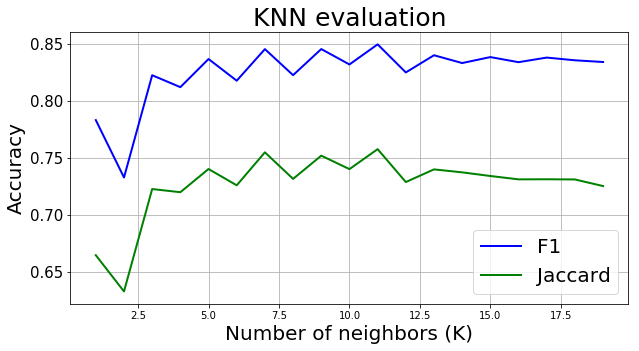

The highest Jaccard similarity index is 0.758 for Number of neighbors (K)= 11
The highest F1 score is 0.85 for Number of neighbors (K)= 11


In [28]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, jaccard_similarity_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
Ks = 20 # number of neighbors for KNN method
Jac_vals = np.zeros((Ks-1))
F1_vals = np.zeros((Ks-1))

for n in range(1, Ks):
    # Build the model
    knn = KNeighborsClassifier(n_neighbors=n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    Jac_kfold_vals = np.zeros((folds))
    f1_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        knn.fit(X[train_index], y[train_index])
        yhat = knn.predict(X[test_index])
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat,
                                     labels = ['PAIDOFF'], average='micro')
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    Jac_vals[n-1] = Jac_kfold_vals.mean()
    F1_vals[n-1] = f1_kfold_vals.mean()

# plot model evaluation and find the optimum parameter
model_par_name = 'Number of neighbors (K)'
model_name = 'KNN'
model_eval_plt(list(range(1, Ks)), F1_vals, Jac_vals, model_name, model_par_name)

**5.2** Build the final KNN model  
Use the K-value that maximizes the model accuracy based on evaluation graph to build the final KNN model

In [29]:
k=11
knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X_train, y_train) 
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')

As you can see, in addition to 'n_neighbors' there are other parameters that can be tuned in an attempt to achive higher accuracy, but we postpone is for now.

##### 4.2 Decision Tree

Decision trees are vary basic classifiers and have been around for a while and mainly replaced by other more sophisticate classifiers. Decision trees have been reborn recently because of their ability to be utilized in more modern classifiers like Random Forest or Gradient Boosting.  (ref:  <a href="https://www.udemy.com/machinelearning/">Machine Learning A-to-Z course on Udemy </a>)   
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Decision%20Trees.png" width="800" align="left"></a>
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Decision%20Trees_2.png" width="800" align="left"></a>


**4.2.1** Parameter tuning

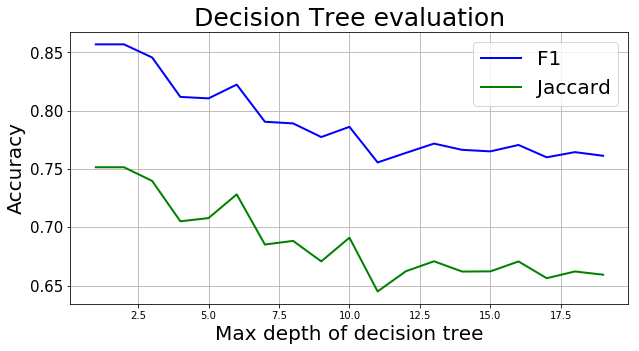

The highest Jaccard similarity index is 0.752 for Max depth of decision tree= 1
The highest F1 score is 0.857 for Max depth of decision tree= 1


In [30]:
from sklearn.tree import DecisionTreeClassifier
maxDepths = 20
f1_vals = np.zeros((maxDepths-1))
Jac_vals = np.zeros((maxDepths-1))
for n in range(1, maxDepths):
    # Build the model
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanTree.fit(X_raw[train_index], y[train_index])
        yhat = loanTree.predict(X_raw[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat,
                                     labels = ['PAIDOFF'], average='micro')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    f1_vals[n-1] = f1_kfold_vals.mean()
    Jac_vals[n-1] = Jac_kfold_vals.mean()


# plot model evaluation and find the optimum parameter
model_par_name = 'Max depth of decision tree'
model_name = 'Decision Tree'
model_eval_plt(list(range(1, maxDepths)), f1_vals, Jac_vals, model_name, model_par_name)


Considering both accuracy metrics, 6 is a better choice for 'max_depth' parameter.

**5.2.2** Build the final decision tree model:

In [31]:
loanTree = DecisionTreeClassifier(criterion="entropy",
                                  max_depth = 6)
# loanTree.fit(X_train,y_train)
loanTree.fit(X_raw,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Aagain we see there are other model parameters that can be tuned in addition to max_depth. For now we keep the default values for other model parameters.

Visualize decision tree

In [ ]:
# # Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

In [32]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

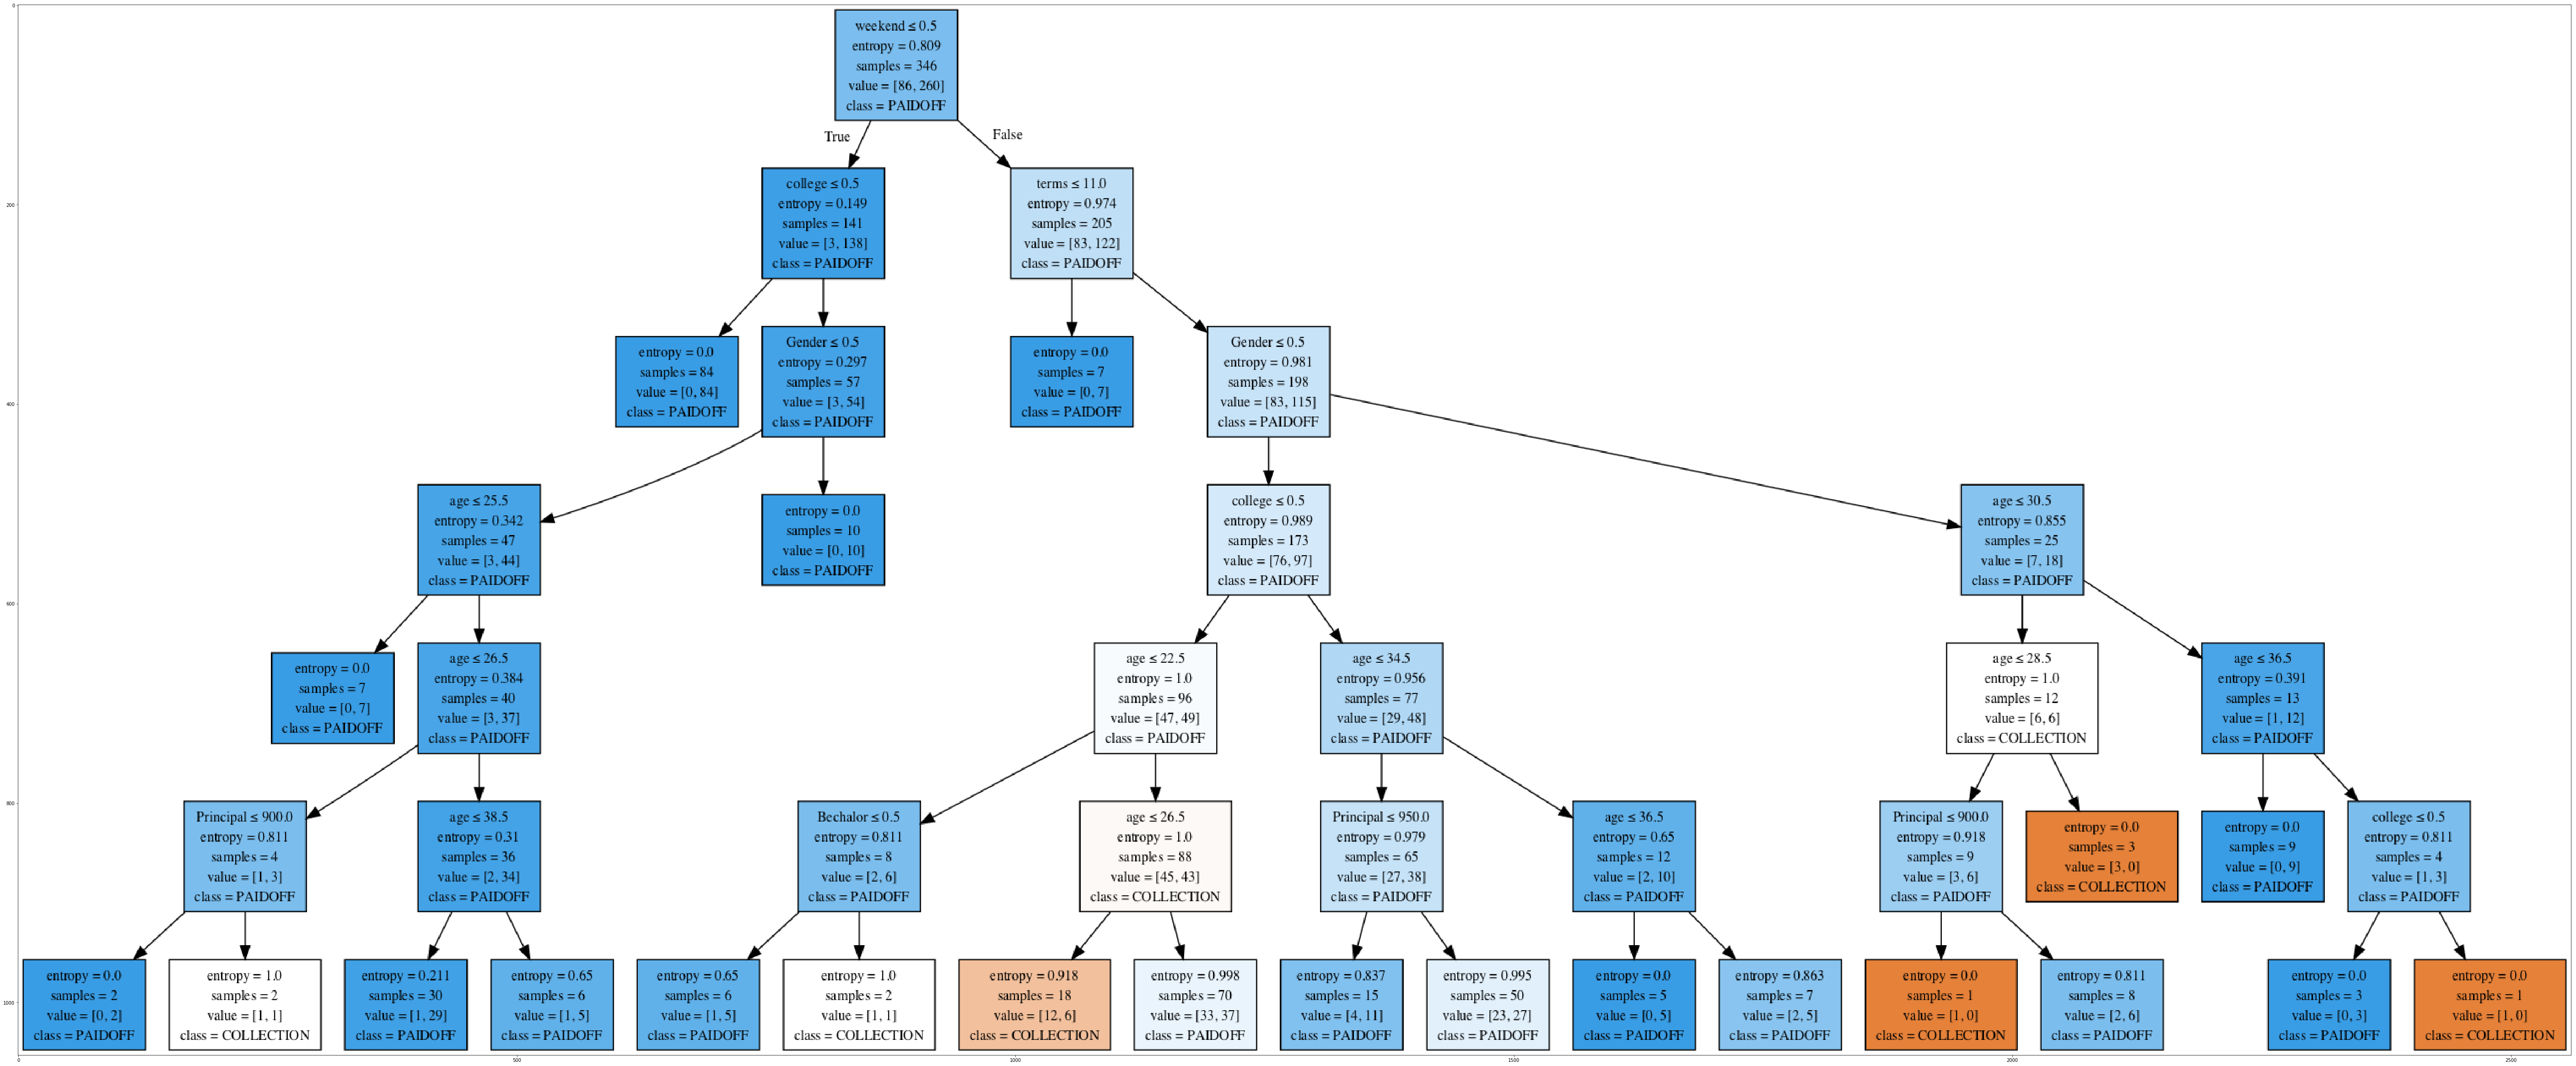

In [33]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,
                         feature_names=featureNames,
                         out_file=dot_data, 
                         class_names= np.unique(targetNames), 
                         filled=True,  
                         special_characters=True,
                         rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Accuracies:
1. Depth1: (138+122)/346 = 0.75
2. Depth2: (84+54+7+115)/346 = 0.75
3. Depth3: (44+10+97+18)/346 = 0.49
4. Depth4: (7+37+49+48+6+12)/346 = 0.46
5. Depth5: (3+34+6+45+38+10+6+3+9+3)/346 = 0.45
6. Depth6: (2+1+29+5+5+1+12+37+11+27+5+5+1+6+3+1)/346 = 0.44

#### 5.3 Support Vector Machine (SVM):

Intuition: The problem is to find the best decision boundry that help us to separate two classess. Then the model will be used to identify the class of new data:    

(ref:  <a href="https://www.udemy.com/machinelearning/">Machine Learning A-to-Z course on Udemy </a>)   
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/SVM1.png" width="800" align="left"></a>


We are basically looking for a boundry with a maximum margin:  

<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/SVM2.png" width="800" align="left"></a>    


What is so special about SVMs?    
Instead of looking at the most standard or most frequent feature values for each class, the SVM looks at the least standard feature values for each class which are actually the support vectors. 

Which **kernel** results in highest accuracy?
Rebuild the model using 4 different kernels, compute the accuracy for each model, select the best kernel.  
Kernels to be tested: 

    1.Linear  
    2.Polynomial  
    3.Radial basis function (RBF)  
    4.Sigmoid  
    
Each of these functions has their own characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

**5.3.1** Parameter tuning:

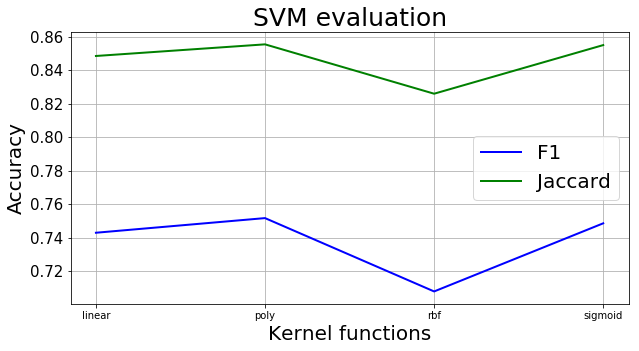

The highest Jaccard similarity index is 0.855 for Kernel functions= poly
The highest F1 score is 0.752 for Kernel functions= poly


In [34]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
n=0
F1_scores = np.zeros(len(kernels))
Jaccard_scores = np.zeros(len(kernels))
MCC_scores = np.zeros(len(kernels))

for myKernel in kernels:
    
    # Build the model
    loanSVM = svm.SVC(C = 1, kernel=myKernel, gamma = 'auto')

    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    MCC_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanSVM.fit(X[train_index], y[train_index])
        yhat = loanSVM.predict(X[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], 
                                     yhat, labels = ['PAIDOFF'], average='micro')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
#         MCC_kfold_vals[n2] = matthews_corrcoef(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    F1_scores[n-1] = f1_kfold_vals.mean()
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    MCC_scores[n-1] = MCC_kfold_vals.mean()
    
    
    n+=1

# plot model evaluation and find the optimum parameter
model_par_name = 'Kernel functions'
model_name = 'SVM'
model_eval_plt(kernels, Jaccard_scores, F1_scores, model_name, model_par_name)


This evaluation graph shows how a polynomial (degree 3, default) works better in terms of higher prediction accuracy when compared with other kernels.

There are other parameters that can be tuned e.g. the degree of the polynomial function. This is beyond the scope of this work. 
The figure shows both polynomial (default degree of 3) and rbf result in same accuracy.

**5.3.2** Build final SVM classifier:

In [35]:
loanSVM = svm.SVC(kernel='poly')
loanSVM.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### 5.4 Logistic Regression

**Intuition:**. 
Logistic regression can be considered as the extension of linear regression to the cases when a categorical variable should be predicted.  
<a href="https://www.sciencedirect.com/topics/medicine-and-dentistry/logistic-regression-analysis"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Logistic_reg_2.png" width="300" align="left"></a>



<a href="https://towardsdatascience.com/how-are-logistic-regression-ordinary-least-squares-regression-related-1deab32d79f5"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Logistic_reg_3.png" width="300" align="left"></a>     


Logistic regression has a regularization parameter called C. Small values of C increase the regularization strength which will create simple models which underfit the data. Big values of C lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data. 
Plot accuracy curves based on different C values to find the best for this dataset.

**5.4.1** Parameter tuning

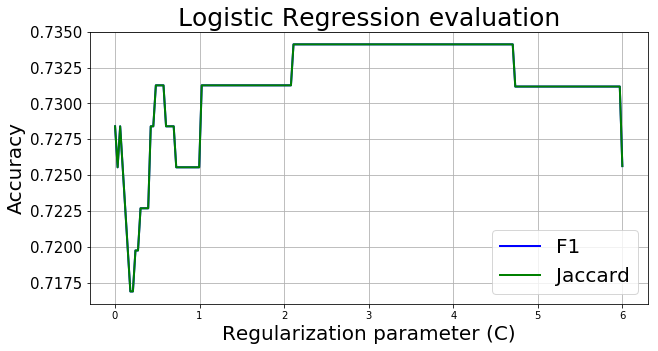

The highest Jaccard similarity index is 0.734 for Regularization parameter (C)= 2.1112010050251255
The highest F1 score is 0.734 for Regularization parameter (C)= 2.1112010050251255


In [36]:
from sklearn.linear_model import LogisticRegression
Cvec = np.linspace(0.001, 6, 200)
n=0
Jaccard_scores = np.zeros(len(Cvec))
F1_scores = np.zeros(len(Cvec))
for myC in Cvec:
    # Build the model
    LR = LogisticRegression(C=myC, solver='liblinear') # liblinear is recommended for smal datasets
    # perform a k-fold cross-validation to estimate the model accuracy
#     folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    Jac_kfold_vals = np.zeros((folds))
    f1_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        LR.fit(X[train_index], y[train_index])
        yhat = LR.predict(X[test_index])
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        f1_kfold_vals[n2] = f1_score(y[test_index], 
                                     yhat, labels = ['PAIDOFF'], average='micro')
        n2+=1   
    # compute the mean accuracy based on accuracy of k-folds 
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    F1_scores[n-1] = Jac_kfold_vals.mean()
    n+=1


    
# plot model evaluation and find the optimum parameter
model_par_name = 'Regularization parameter (C)'
model_name = 'Logistic Regression'
model_eval_plt(list(Cvec), F1_scores, Jaccard_scores, model_name, model_par_name)

**5.4.2** Build final Logistic Regression classifier.

In [37]:
LR = LogisticRegression(C=2.2, solver='liblinear')
# LR.fit(X_train,y_train)
LR.fit(X,y)

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### 5.5 Random Forest model  
Random forest model is a type of ensemble learning where a machine learning algorithm leverages many different other machine larning algorithms. Random forest method combines a lot of decision tree methods. 
Basically you first select the number of trees, then build each one of those decision trees based on a randomly selected subset of data. At the end when you have a new data point to predict, use each decision tree to predict the outcome for that new data point. The final result will be the category that received the highest vote from all trees.

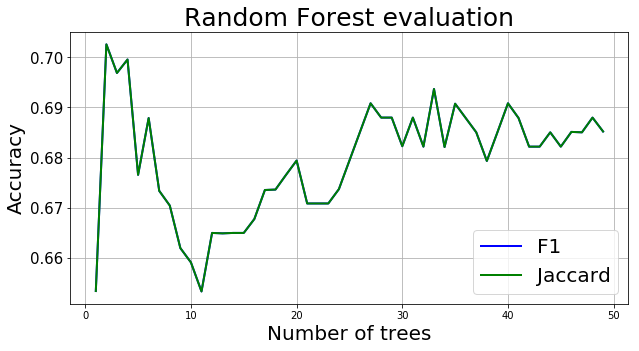

The highest Jaccard similarity index is 0.703 for Number of trees= 2
The highest F1 score is 0.703 for Number of trees= 2


In [38]:
from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
# RF.fit(X, y)

n_estimators_vec = range(1, 50)
n=0
Jaccard_scores = np.zeros(len(n_estimators_vec))
F1_scores = np.zeros(len(n_estimators_vec))
for my_n_estimators in n_estimators_vec:
    # Build the model
    RF = RandomForestClassifier(n_estimators = my_n_estimators,
                                criterion = 'entropy', 
                               random_state = 0) 
    # perform a k-fold cross-validation to estimate the model accuracy
#     folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    Jac_kfold_vals = np.zeros((folds))
    f1_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        RF.fit(X_raw[train_index], y[train_index])
        yhat = RF.predict(X_raw[test_index])
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        f1_kfold_vals[n2] = f1_score(y[test_index], 
                                     yhat, labels = ['PAIDOFF'], average='micro')
        n2+=1   
    # compute the mean accuracy based on accuracy of k-folds 
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    F1_scores[n-1] = Jac_kfold_vals.mean()
    n+=1


    
# plot model evaluation and find the optimum parameter
model_par_name = 'Number of trees'
model_name = 'Random Forest'
model_eval_plt(list(n_estimators_vec), F1_scores, Jaccard_scores, model_name, model_par_name)



#### Build the final Random Forest model:

In [39]:
RF = RandomForestClassifier(n_estimators = 2,
                                criterion = 'entropy', 
                               random_state = 0) 
RF.fit(X_raw,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 6. Use models to predict the target variable in new data

### 6.1 Preprocessing of new datset:

**Download** and **load** the new dataset:

In [40]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
!wget -O loan_test.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
print('Download complete!')

--2019-02-26 15:53:01--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/plain]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-02-26 15:53:01 (8.27 MB/s) - 'loan_test.csv' saved [3642/3642]

Download complete!


In [41]:
test_df = pd.read_csv('loan_test.csv')
test_df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female


**Preprocess** new dataset  
Preprocess in the SAME way as training data.

In [42]:
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # Monday:0, Sunday:6

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)
# test_df.drop(['education', 'Master or Above', 'effective_date', 'due_date'], inplace=True, axis = 1)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head(3)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Bechalor,High School or Below,Master or Above,college,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,1,0,0,0,0
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,0,0,1,0,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,0,1,0,0,1


Extract **features** and **target** data from new dataset:

In [43]:


# X_new = test_df['Principal', 'terms', 'age', 'Gender', 'dayofweek', 'Bechalor', 'High School or Below', 'college']
features = ['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
            'High School or Below', 'college', 'Master or Above']
# features = ['Principal', 'terms', 'age']
X_new = test_df[features]
X_new.head(3)

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college,Master or Above
0,1000,30,50,1,0,1,0,0,0
1,300,7,35,0,1,0,0,0,1
2,1000,30,43,1,1,0,1,0,0


In [44]:
X_new.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
weekend                 int64
Bechalor                uint8
High School or Below    uint8
college                 uint8
Master or Above         uint8
dtype: object

In [45]:
y_new = test_df['loan_status'].values
y_new[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

**Normalize** feature data

In [46]:
X_new_raw = X_new.values # for decision tree and random forest
X_new = preprocessing.StandardScaler().fit(X_new).transform(X_new)
X_new[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677, -0.19611614],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677,  5.09901951]])

In [ ]:
# # Feature selection on new data SAME as what we did on training data
# X_new = fvalue_selector.transform(X_new)

### 6.2 Predictive modeling on new dataset

In [47]:
# KNN
# Notice that we are now using the model we have built previously
yhat = knn.predict(X_new)
print('Jaccard similarity index = {:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('F1 score                 = {:3.3}'.format(f1_score(y_new, yhat,
                                     labels = ['PAIDOFF'], average='micro')))

Jaccard similarity index = 0.648
F1 score                 = 0.782


In [48]:
# Descision Tree
yhat = loanTree.predict(X_new_raw)
print('Jaccard similarity index = {:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('F1 score                 = {:3.3}'.format(f1_score(y_new, yhat,
                                     labels = ['PAIDOFF'], average='micro')))

Jaccard similarity index = 0.685
F1 score                 = 0.805


In [49]:
# SVM
yhat = loanSVM.predict(X_new)
print('Jaccard similarity index = {:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('F1 score                 = {:3.3}'.format(f1_score(y_new, yhat,
                                     labels = ['PAIDOFF'], average='micro')))

Jaccard similarity index = 0.722
F1 score                 = 0.839


In [50]:
# Logistic regression
yhat = LR.predict(X_new)
yhat_prob = LR.predict_proba(X_new) # for LogLoss score that works on the probability of model prediction
print('Jaccard similarity index = {:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('F1 score                 = {:3.3}'.format(f1_score(y_new, yhat,
                                     labels = ['PAIDOFF'], average='micro')))

Jaccard similarity index = 0.741
F1 score                 = 0.851


In [51]:
# Random Forest
yhat = RF.predict(X_new_raw)
print('Jaccard similarity index = {:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
print('F1 score                 = {:3.3}'.format(f1_score(y_new, yhat,
                                     labels = ['PAIDOFF'], average='micro')))

Jaccard similarity index = 0.667
F1 score                 = 0.786


# Report


Table summarizes performance of models in predicting the loan payment.


| Algorithm          | Jaccard |  F1 |
|--------------------|---------|-----|
| KNN                |   0.65| 0.78|
| Decision Tree      |      0.68|0.80|
| SVM                |      0.72|0.84|
| LogisticRegression |        0.74|  0.85|
| Random Forest      |  0.66|0.78|



- Without k-fold cross-validation, the accuracies were lower. 
- Using **Univariate Feature Selectin** based on the ANOVA F-value (with 5 best ANOVA F-values) did not improve the accuracies.



***Conclusion:***   
All five models perform similary, but Logistic regresssion and SVM show slightly higher accuracies when compared to other classifiers.


This notebook is inspired by the contents from final project notebook for "Machine Learning" <a href="https://www.coursera.org/learn/machine-learning-with-python">course </a> by IBM on coursera.
